In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPool2D,GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

#CIFAR-10 dataset

[9]


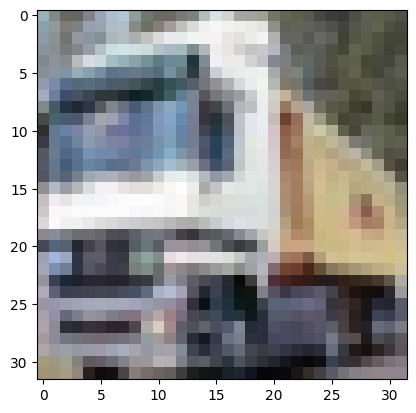

In [ ]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()

print(train_labels[1])
plt.imshow(train_images[1], cmap="Greys_r")

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(
    (train_images.astype(np.float32) / 255, train_labels.reshape(-1).astype(np.int32)))
train_data = train_data.shuffle(buffer_size=60000).batch(128)

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.astype(np.float32) / 255, test_labels.reshape(-1).astype(np.int32))).batch(128)

# Inception Module

In [ ]:
def inception_block(x, filters):
    c1_1 = Conv2D(filters, 1, activation = tf.nn.relu, padding='same')(x)
    c1_3 = Conv2D(filters, 1, activation = tf.nn.relu, padding='same')(x)
    c1_3 = Conv2D(filters, 3, activation = tf.nn.relu, padding='same')(c1_3)
    c1_5 = Conv2D(filters, 1, activation = tf.nn.relu, padding='same')(x)
    c1_5 = Conv2D(filters, 5, activation = tf.nn.relu, padding='same')(c1_5)
    p1 = MaxPool2D(3, 1, padding='same')(x)
    p1 = Conv2D(filters, 1, padding='same')(p1)
    final = tf.concat([c1_1,c1_3,c1_5,p1], axis=-1)
    return final

In [ ]:
def create_model(input_shape, num_classes, num_blocks, filters):
    input = Input(shape=input_shape)
    x = input
    # Add ResNet blocks
    for filter in filters:
      for _ in range(num_blocks):
        x = inception_block(x, filter)
      x = MaxPool2D(padding="same")(x)

    pooled = GlobalAveragePooling2D()(x)
    output = Dense(num_classes)(pooled)

    model = Model(inputs=input, outputs=output)
    return model

In [ ]:
input_shape = (32, 32, 3)  # CIFAR-10/100 image shape
num_classes = 10  # CIFAR-10 has 10 classes, CIFAR-100 has 100 classes
num_blocks = 3  # Number of inception blocks
filters = [32, 64, 128]  # Number of filters in the first convolutional layer

In [ ]:
model = create_model(input_shape, num_classes, num_blocks, filters)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 32)           128       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 32, 32, 32)           128       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 3)            0         ['input_1[0][0]']             
 D)                                                                                           

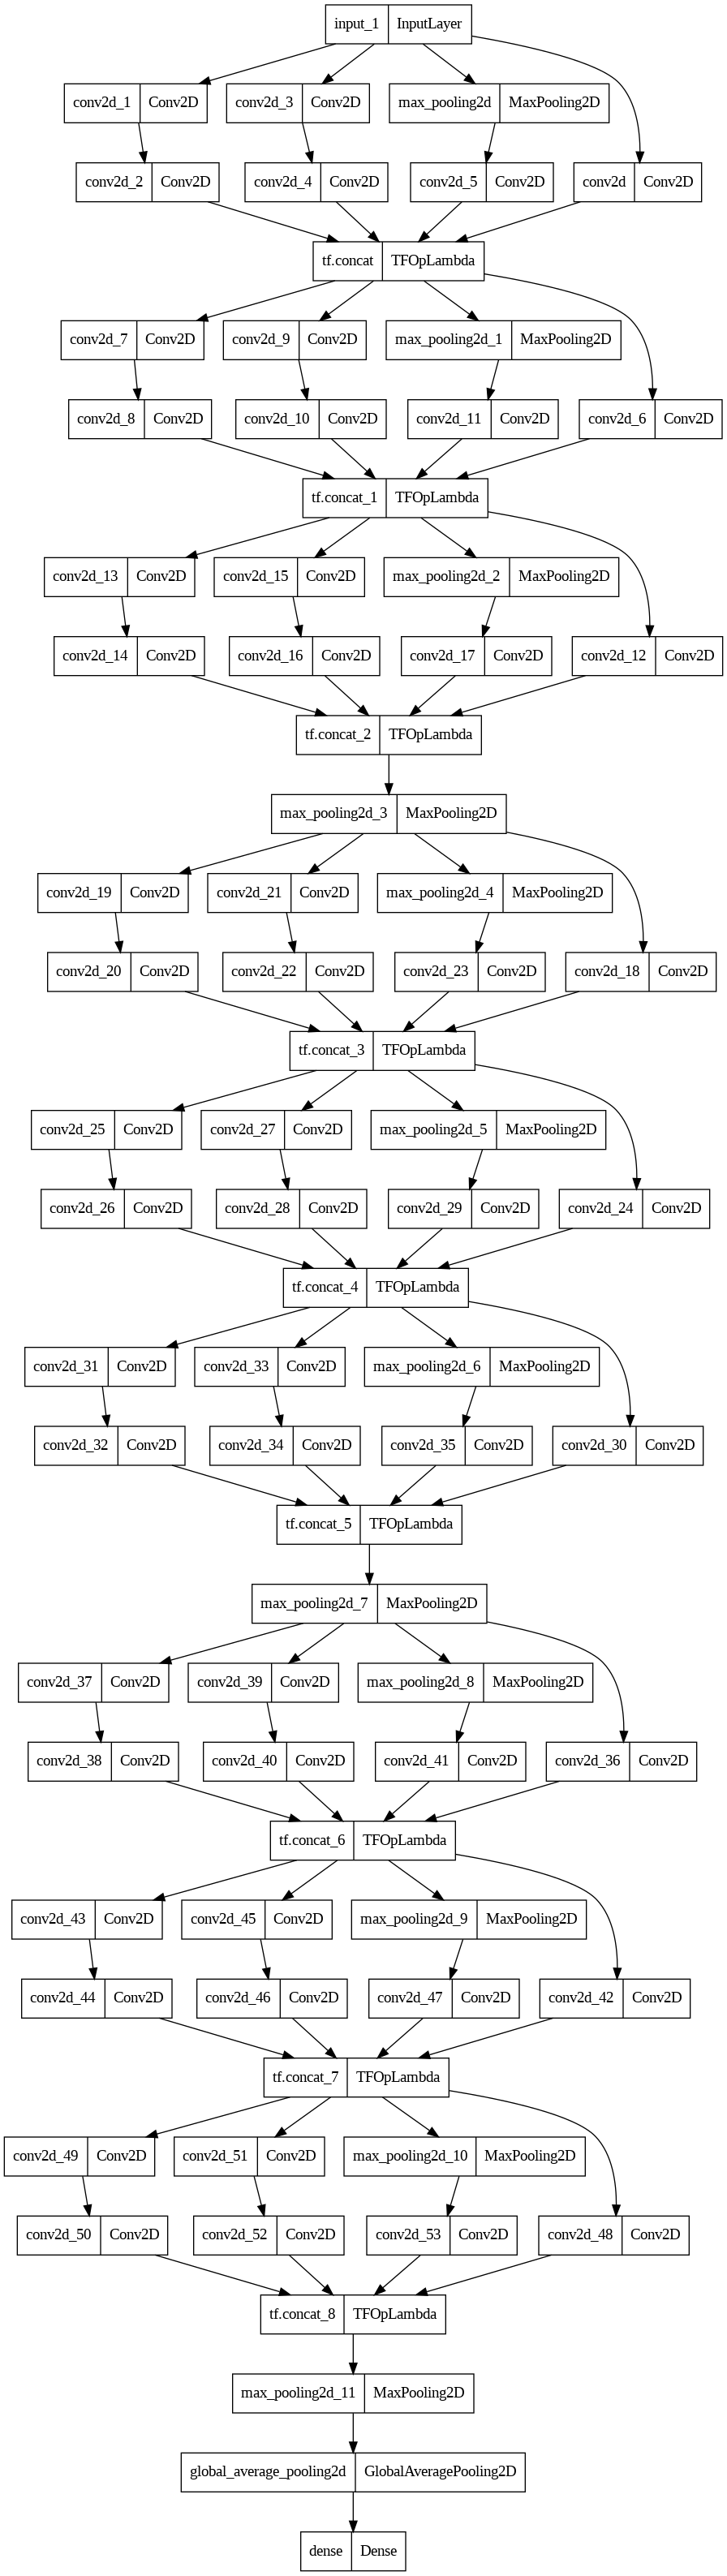

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_metric = tf.metrics.SparseCategoricalAccuracy()
model.compile(optimizer=Adam(), loss=loss_fn, metrics=[accuracy_metric], jit_compile=True)

In [ ]:
model.fit(train_data, batch_size=64, epochs=10, validation_data=(test_data))

Epoch 1/10
391/391 [==============================] - 97s 170ms/step - loss: 1.6935 - sparse_categorical_accuracy: 0.3675 - val_loss: 1.3094 - val_sparse_categorical_accuracy: 0.5174
Epoch 2/10
391/391 [==============================] - 53s 135ms/step - loss: 1.1563 - sparse_categorical_accuracy: 0.5779 - val_loss: 1.0395 - val_sparse_categorical_accuracy: 0.6301
Epoch 3/10
391/391 [==============================] - 50s 128ms/step - loss: 0.8852 - sparse_categorical_accuracy: 0.6857 - val_loss: 0.8096 - val_sparse_categorical_accuracy: 0.7157
Epoch 4/10
391/391 [==============================] - 52s 134ms/step - loss: 0.7140 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.6796 - val_sparse_categorical_accuracy: 0.7623
Epoch 5/10
391/391 [==============================] - 50s 128ms/step - loss: 0.5777 - sparse_categorical_accuracy: 0.7948 - val_loss: 0.6254 - val_sparse_categorical_accuracy: 0.7843
Epoch 6/10
391/391 [==============================] - 50s 128ms/step - loss: 0.4846 -

Inception module on CIFAR-10 \\
batch size = 64 \\
filters = [32,64,128] \\
No. of inception blocks = 3

Training Accuracy - **91.01** \\
Test Accuracy - **81.54**

In [ ]:
model.fit(train_data, batch_size=256, epochs=10, validation_data=(test_data))

Epoch 1/10
391/391 [==============================] - 50s 128ms/step - loss: 0.2239 - sparse_categorical_accuracy: 0.9198 - val_loss: 0.5404 - val_sparse_categorical_accuracy: 0.8440
Epoch 2/10
391/391 [==============================] - 50s 128ms/step - loss: 0.1893 - sparse_categorical_accuracy: 0.9334 - val_loss: 0.6458 - val_sparse_categorical_accuracy: 0.8070
Epoch 3/10
391/391 [==============================] - 50s 128ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.9411 - val_loss: 0.6937 - val_sparse_categorical_accuracy: 0.8225
Epoch 4/10
391/391 [==============================] - 50s 128ms/step - loss: 0.1490 - sparse_categorical_accuracy: 0.9471 - val_loss: 0.7040 - val_sparse_categorical_accuracy: 0.8279
Epoch 5/10
391/391 [==============================] - 50s 128ms/step - loss: 0.1343 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.6394 - val_sparse_categorical_accuracy: 0.8419
Epoch 6/10
391/391 [==============================] - 50s 127ms/step - loss: 0.1229 -

Batch size changed

Inception module on CIFAR-10 \\
batch size = 128 \\
filters = [32,64,128] \\
No. of inception blocks = 3

Training Accuracy - **96.81** \\
Test Accuracy - **83.53**

# ResNet

In [ ]:
def residual_block(x, n_filters):
  conv1 = Conv2D(n_filters, 3, activation=tf.nn.relu, padding="same")(x)
  conv2 = Conv2D(n_filters, 3, padding="same")(conv1)
  return tf.nn.relu(conv2 + x)

In [ ]:
def resnet(input_shape, num_classes, num_blocks, filter):
    input = Input(shape=input_shape)
    x = Conv2D(filter, 3, padding="same")(input)
    # Add ResNet blocks
    for _ in range(num_blocks):
        x = residual_block(x, filter)

    #b1 = residual_block()

    pooled = GlobalAveragePooling2D()(x)
    output = Dense(num_classes)(pooled)

    model = Model(inputs=input, outputs=output)
    return model

In [ ]:
input_shape = (32, 32, 3)  # CIFAR-10/100 image shape
num_classes = 10  # CIFAR-10 has 10 classes, CIFAR-100 has 100 classes
num_blocks = 3  # Number of ResNet blocks
filter = 32  # Number of filters in the first convolutional layer

In [ ]:
model = resnet(input_shape, num_classes, num_blocks, filter)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_54 (Conv2D)          (None, 32, 32, 32)           896       ['input_2[0][0]']             
                                                                                                  
 conv2d_55 (Conv2D)          (None, 32, 32, 32)           9248      ['conv2d_54[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)          (None, 32, 32, 32)           9248      ['conv2d_55[0][0]']           
                                                                                            

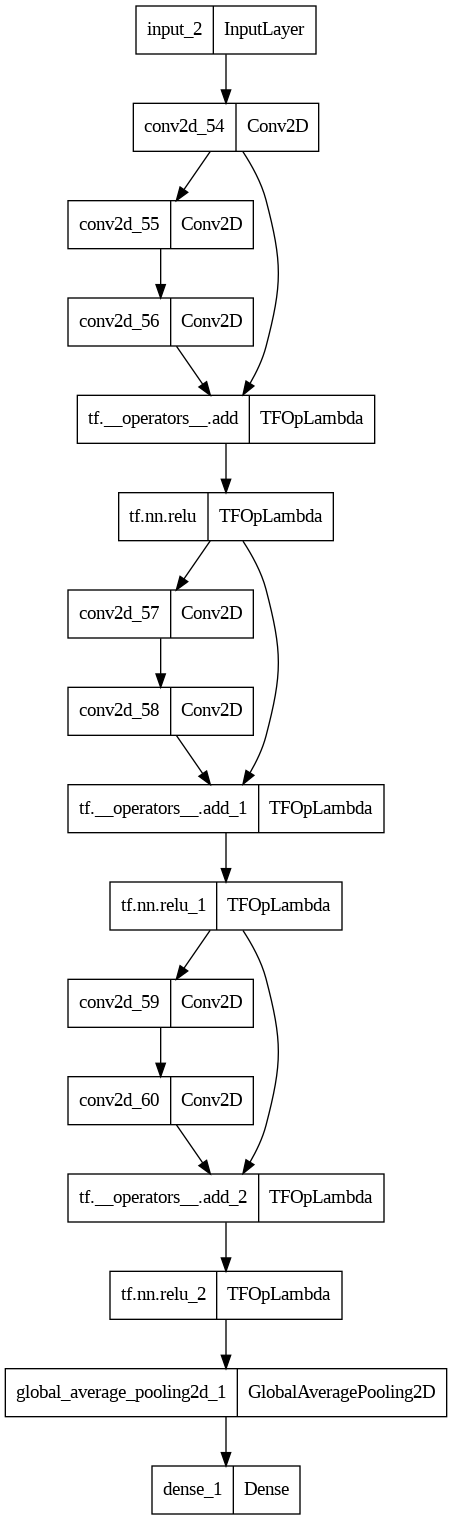

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_metric = tf.metrics.SparseCategoricalAccuracy()
model.compile(optimizer=Adam(), loss=loss_fn, metrics=[accuracy_metric], jit_compile=True)

In [ ]:
model.fit(train_data, batch_size=64, epochs=5, validation_data=(test_data))

Epoch 1/5
391/391 [==============================] - 16s 31ms/step - loss: 1.9287 - sparse_categorical_accuracy: 0.2606 - val_loss: 1.6555 - val_sparse_categorical_accuracy: 0.3897
Epoch 2/5
391/391 [==============================] - 8s 21ms/step - loss: 1.5744 - sparse_categorical_accuracy: 0.4181 - val_loss: 1.5305 - val_sparse_categorical_accuracy: 0.4388
Epoch 3/5
391/391 [==============================] - 9s 22ms/step - loss: 1.4263 - sparse_categorical_accuracy: 0.4795 - val_loss: 1.3709 - val_sparse_categorical_accuracy: 0.4941
Epoch 4/5
391/391 [==============================] - 8s 21ms/step - loss: 1.3237 - sparse_categorical_accuracy: 0.5196 - val_loss: 1.2703 - val_sparse_categorical_accuracy: 0.5416
Epoch 5/5
391/391 [==============================] - 9s 22ms/step - loss: 1.2372 - sparse_categorical_accuracy: 0.5542 - val_loss: 1.2236 - val_sparse_categorical_accuracy: 0.5587


Resnet blocks = 3 \\
batch size = 64 \\
filter = 32 \\

Training Accuracy - **55.42** \\
Test Accuracy - **55.87**

In [ ]:
model = resnet(input_shape, num_classes, 5, filter)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 32, 32, 32)           896       ['input_3[0][0]']             
                                                                                                  
 conv2d_62 (Conv2D)          (None, 32, 32, 32)           9248      ['conv2d_61[0][0]']           
                                                                                                  
 conv2d_63 (Conv2D)          (None, 32, 32, 32)           9248      ['conv2d_62[0][0]']           
                                                                                            

In [ ]:
model.compile(optimizer=Adam(), loss=loss_fn, metrics=[accuracy_metric], jit_compile=True)

In [ ]:
model.fit(train_data, batch_size=64, epochs=5, validation_data=(test_data))

Epoch 1/5
391/391 [==============================] - 21s 45ms/step - loss: 1.8343 - sparse_categorical_accuracy: 0.3369 - val_loss: 1.6797 - val_sparse_categorical_accuracy: 0.3460
Epoch 2/5
391/391 [==============================] - 13s 34ms/step - loss: 1.5260 - sparse_categorical_accuracy: 0.4293 - val_loss: 1.3558 - val_sparse_categorical_accuracy: 0.4912
Epoch 3/5
391/391 [==============================] - 14s 35ms/step - loss: 1.3337 - sparse_categorical_accuracy: 0.5058 - val_loss: 1.3148 - val_sparse_categorical_accuracy: 0.5107
Epoch 4/5
391/391 [==============================] - 13s 34ms/step - loss: 1.2154 - sparse_categorical_accuracy: 0.5551 - val_loss: 1.1757 - val_sparse_categorical_accuracy: 0.5698
Epoch 5/5
391/391 [==============================] - 13s 33ms/step - loss: 1.1233 - sparse_categorical_accuracy: 0.5936 - val_loss: 1.1693 - val_sparse_categorical_accuracy: 0.5830


Resnet blocks =  \\
batch size = 64 \\
filter = 32 \\

Training Accuracy - **59.36** \\
Test Accuracy - **58.30**

In [ ]:
model = resnet(input_shape, num_classes, 10, filter)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_72 (Conv2D)          (None, 32, 32, 32)           896       ['input_4[0][0]']             
                                                                                                  
 conv2d_73 (Conv2D)          (None, 32, 32, 32)           9248      ['conv2d_72[0][0]']           
                                                                                                  
 conv2d_74 (Conv2D)          (None, 32, 32, 32)           9248      ['conv2d_73[0][0]']           
                                                                                            

In [ ]:
model.compile(optimizer=Adam(), loss=loss_fn, metrics=[accuracy_metric], jit_compile=True)

In [ ]:
model.fit(train_data, batch_size=64, epochs=5, validation_data=(test_data))

Epoch 1/5
391/391 [==============================] - 37s 75ms/step - loss: 1.8637 - sparse_categorical_accuracy: 0.3321 - val_loss: 1.6272 - val_sparse_categorical_accuracy: 0.3909
Epoch 2/5
391/391 [==============================] - 25s 64ms/step - loss: 1.5283 - sparse_categorical_accuracy: 0.4321 - val_loss: 1.3657 - val_sparse_categorical_accuracy: 0.5058
Epoch 3/5
391/391 [==============================] - 25s 64ms/step - loss: 1.3225 - sparse_categorical_accuracy: 0.5184 - val_loss: 1.2168 - val_sparse_categorical_accuracy: 0.5517
Epoch 4/5
391/391 [==============================] - 25s 64ms/step - loss: 1.2044 - sparse_categorical_accuracy: 0.5650 - val_loss: 1.1442 - val_sparse_categorical_accuracy: 0.5808
Epoch 5/5
391/391 [==============================] - 26s 65ms/step - loss: 1.0898 - sparse_categorical_accuracy: 0.6084 - val_loss: 1.0137 - val_sparse_categorical_accuracy: 0.6380


Resnet blocks = 10 \\
batch size = 64 \\
filter = 32 \\

Training Accuracy - **60.84** \\
Test Accuracy - **63.80**

In [ ]:
model = resnet(input_shape, num_classes, 10, 64)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_93 (Conv2D)          (None, 32, 32, 64)           1792      ['input_5[0][0]']             
                                                                                                  
 conv2d_94 (Conv2D)          (None, 32, 32, 64)           36928     ['conv2d_93[0][0]']           
                                                                                                  
 conv2d_95 (Conv2D)          (None, 32, 32, 64)           36928     ['conv2d_94[0][0]']           
                                                                                            

In [ ]:
model.compile(optimizer=Adam(), loss=loss_fn, metrics=[accuracy_metric], jit_compile=True)

In [ ]:
model.fit(train_data, batch_size=64, epochs=5, validation_data=(test_data))

Epoch 1/5
391/391 [==============================] - 73s 161ms/step - loss: 1.8460 - sparse_categorical_accuracy: 0.3403 - val_loss: 1.5757 - val_sparse_categorical_accuracy: 0.4004
Epoch 2/5
391/391 [==============================] - 58s 147ms/step - loss: 1.4554 - sparse_categorical_accuracy: 0.4478 - val_loss: 1.2940 - val_sparse_categorical_accuracy: 0.5248
Epoch 3/5
391/391 [==============================] - 56s 143ms/step - loss: 1.2228 - sparse_categorical_accuracy: 0.5505 - val_loss: 1.1963 - val_sparse_categorical_accuracy: 0.5499
Epoch 4/5
391/391 [==============================] - 55s 141ms/step - loss: 1.0676 - sparse_categorical_accuracy: 0.6132 - val_loss: 1.0770 - val_sparse_categorical_accuracy: 0.6142
Epoch 5/5
391/391 [==============================] - 56s 142ms/step - loss: 0.9519 - sparse_categorical_accuracy: 0.6576 - val_loss: 0.9262 - val_sparse_categorical_accuracy: 0.6681


Resnet blocks = 10 \\
batch size = 64 \\
filter = 64 \\

Training Accuracy - **65.76** \\
Test Accuracy - **66.81**

In [ ]:
model = resnet(input_shape, num_classes, 10, 128)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_114 (Conv2D)         (None, 32, 32, 128)          3584      ['input_6[0][0]']             
                                                                                                  
 conv2d_115 (Conv2D)         (None, 32, 32, 128)          147584    ['conv2d_114[0][0]']          
                                                                                                  
 conv2d_116 (Conv2D)         (None, 32, 32, 128)          147584    ['conv2d_115[0][0]']          
                                                                                            

In [ ]:
model.compile(optimizer=Adam(), loss=loss_fn, metrics=[accuracy_metric], jit_compile=True)

In [ ]:
model.fit(train_data, batch_size=64, epochs=5, validation_data=(test_data))

Epoch 1/5
391/391 [==============================] - 146s 346ms/step - loss: 2.0864 - sparse_categorical_accuracy: 0.2877 - val_loss: 1.7501 - val_sparse_categorical_accuracy: 0.3331
Epoch 2/5
391/391 [==============================] - 126s 322ms/step - loss: 1.5874 - sparse_categorical_accuracy: 0.4022 - val_loss: 1.4865 - val_sparse_categorical_accuracy: 0.4594
Epoch 3/5
391/391 [==============================] - 126s 323ms/step - loss: 1.3294 - sparse_categorical_accuracy: 0.5108 - val_loss: 1.2742 - val_sparse_categorical_accuracy: 0.5238
Epoch 4/5
391/391 [==============================] - 126s 323ms/step - loss: 1.1404 - sparse_categorical_accuracy: 0.5853 - val_loss: 1.0992 - val_sparse_categorical_accuracy: 0.5979
Epoch 5/5
391/391 [==============================] - 126s 322ms/step - loss: 1.0118 - sparse_categorical_accuracy: 0.6351 - val_loss: 1.0094 - val_sparse_categorical_accuracy: 0.6414


Resnet blocks = 10 \\
batch size = 64 \\
filter = 128 \\

Training Accuracy - **63.51** \\
Test Accuracy - **64.14**